In [1]:
import yfinance as yf
import pandas as pd
import sys
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import os 
from data_manip import df_timestamps, dataset_c, pred_plot, pred_new
from models import LSTMModel
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # which gpu to use
%load_ext autoreload
%autoreload 2

In [3]:
# msft = yf.Ticker("PLUG")
# hist = msft.history(period="max")
PTE = yf.download('PTE','1990-01-01','2024-08-01')[['Close']]
ACB = yf.download('ACB','1990-01-01','2024-08-01')[['Close']]
VFF = yf.download('VFF','1990-01-01','2024-08-01')[['Close']]
PLUG = yf.download('PLUG','1990-01-01','2024-08-01')[['Close']]
SNAP = yf.download('SNAP','1990-01-01','2024-08-01')[['Close']]
AVTX = yf.download('AVTX','1990-01-01','2024-08-01')[['Close']]
AAPL = yf.download('AAPL','1990-01-01','2024-08-01')[['Close']]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Plots for closing price 

<AxesSubplot:xlabel='Date'>

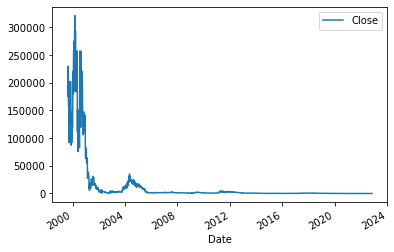

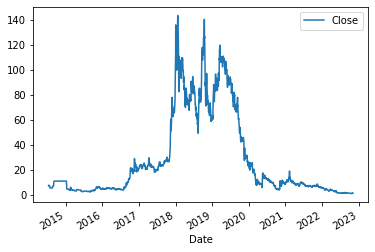

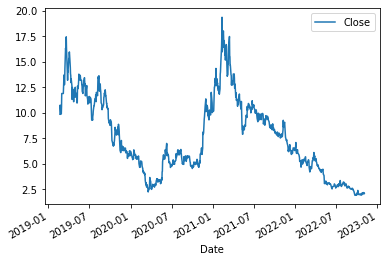

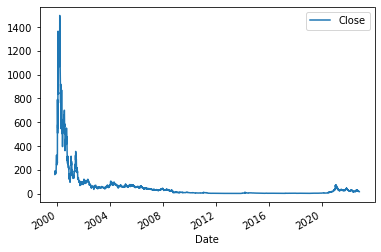

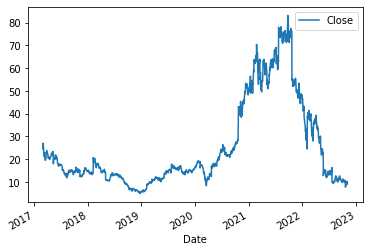

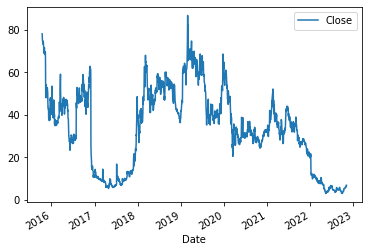

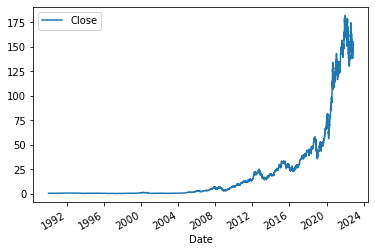

In [4]:
PTE.plot()
ACB.plot()
VFF.plot()
PLUG.plot()
SNAP.plot()
AVTX.plot()
AAPL.plot()

# Data Prep

In [5]:
time_p = 10 # how many time steps you want to look back
# you can change which stock from above variables or can add any other data!
df_ts = df_timestamps(VFF,time_p) # return dataframe with timestampps
cols = [col for col in df_ts.columns if col not in ['Date', 'True_Target']] # take only selected columns
scaler = MinMaxScaler(feature_range=(0, 1)) # transform to between 0 and 1
df_ts['True_Target'] = scaler.fit_transform(df_ts['True_Target'].values.reshape(-1,1)) 
X = df_ts[cols].values # converted to numpy
y = df_ts['True_Target'].values # converted to numpy 
X_train, y_train = X[:X.shape[0] - round(1677 * 0.2)], y[:y.shape[0] - round(1677 * 0.2)]
X_test, y_test = X[-round(1677 * 0.2):], y[-round(1677 * 0.2):]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 926/936 [00:03<00:00, 268.06it/s]


In [11]:
batch_size = 32
dataset_train = dataset_c(X_train,y_train)
dataset_test = dataset_c(X_test,y_test)
data_loader_train = DataLoader(dataset_train, batch_size = batch_size)
data_loader_test = DataLoader(dataset_train, batch_size = batch_size)

In [12]:
model = LSTMModel().cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [13]:
epochs = 100
for epoch in tqdm(range(epochs)):
    running_loss = 0
    for data in data_loader_train:
        inputs = data[0].reshape(data[0].shape[0],time_p,1).float().cuda()
        labels = data[1].float().cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    if epoch % 10 == 0:
        running_loss = running_loss / len(data_loader_train)
        print(f"Loss: {running_loss}")
#     c = 0
#     S,T = pred_plot(model, 100, VFF, X, scaler, False)
#     for i in range(len(S)-1):
#         pred_diff = S[i+1] - S[i]
#         true_diff = T[i+1] - T[i]

#         if np.sign(pred_diff) == np.sign(true_diff):
#             c+=1
#     print(f"{c / (len(S)-1):.2f}")   

  4%|█████████▍                                                                                                                                                                                                                                 | 4/100 [00:00<00:05, 17.03it/s]

Loss: 0.10385800313547645


 14%|████████████████████████████████▊                                                                                                                                                                                                         | 14/100 [00:00<00:05, 17.20it/s]

Loss: 0.005825773368614088


 24%|████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 24/100 [00:01<00:04, 17.08it/s]

Loss: 0.004979758154245485


 34%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 34/100 [00:01<00:03, 17.19it/s]

Loss: 0.0036452581131781792


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 44/100 [00:02<00:03, 17.06it/s]

Loss: 0.0031651905109787264


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 54/100 [00:03<00:02, 17.25it/s]

Loss: 0.0027952125459897183


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 64/100 [00:03<00:01, 18.02it/s]

Loss: 0.0025212411258651534


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 74/100 [00:04<00:01, 17.07it/s]

Loss: 0.002299569887231643


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 84/100 [00:04<00:00, 17.48it/s]

Loss: 0.0021148968777484505


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 94/100 [00:05<00:00, 17.17it/s]

Loss: 0.0019748422277380564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.27it/s]


# Prediction

In [14]:
print(f"Predicted for tomorrow: ${float(pred_new(model, VFF, time_p,scaler)):.2f}")

Predicted for tomorrow: $2.35


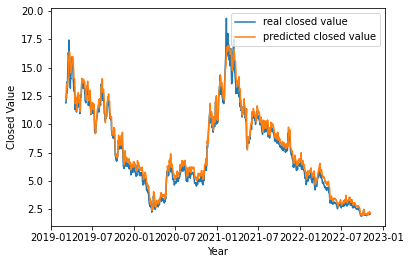

In [15]:
S,T = pred_plot(model, time_p, VFF, X, scaler, True)
# We can see that it clearly fits the model however, don't let these prediction fools you as price prediction is 
# more complicated than only using LSTM model! 